# Structure and Interpretation of Classical Mechanics

## Chapter 1

In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import scipy
from jax import grad, jit, vmap, random
import jax.scipy.optimize
import matplotlib.pyplot as plt

### Harmonic Oscillator Path-Finding

In [28]:
m = 1
k = 1
t0 = 0
t1 = .5*jnp.pi
q0 = 1
q1 = 0
dt = .01
t = jnp.arange(t0,t1,dt)
N = len(t)
# build derivative matrix
D = np.zeros((N,N))
np.fill_diagonal(D[:,1:],.5/dt)
np.fill_diagonal(D[1:,:],-.5/dt)
D[0,0] = -1./dt
D[0,1] = 1./dt
D[N-1,N-1] = 1./dt
D[N-1,N-2] = -1./dt
jD = jnp.copy(D)
print(f"N={N}")

N=158


In [29]:

def L(Gamma_qi):
  ti,qi,Dqi = Gamma_qi
  return .5*m*Dqi**2 - .5*k*qi**2
def S(Gamma_qi):
  return jax.scipy.integrate.trapezoid(L(Gamma_qi),Gamma_qi[0])
def Dt(Dj,qi):
  # ffd on first, cfd on middle, bfd on last
  return Dj@qi

In [30]:

q_exact = jnp.cos(t)
Dq_exact = -jnp.sin(t)
Gamma_q_exact = jnp.array([t,q_exact,Dq_exact])
S_exact = S(Gamma_q_exact)
print(f"Exact Action: {np.round(S_exact,3)}")

Dq_2 = Dt(jD,q_exact)
print(f"Finite difference good?: {jnp.allclose(Dq_2,Dq_exact,atol=.01)}")
q_pert = (t-t0)*(t-t1)*jnp.sin(t)**2
Dq_pert=  Dt(jD,q_pert)
Gamma_q_pert = (t,q_pert,Dq_pert)
S_pert = S(Gamma_q_pert)
print(f"Perturbed Action: {np.round(S_pert,3)}")

Exact Action: -0.0
Finite difference good?: True
Perturbed Action: 0.28300002217292786


In [31]:
def min_wrapper(qi,ti,q0i,q1i):
  start = jnp.array([q0i])
  end = jnp.array([q1i])
  c1 = jnp.concat((start,qi))
  q_test = jnp.concat((c1,end))
  Dq_test = Dt(jD,q_test)
  Gamma_q_test = [ti,q_test,Dq_test]
  S_test = S(Gamma_q_test)
  return S_test
x0 = jnp.zeros(N-2)
print(q0,q1)
result = jax.scipy.optimize.minimize(min_wrapper,x0,args=(t,q0,q1),method="BFGS")
q_out = jnp.concat((jnp.concat((jnp.array([q0]),result.x)),jnp.array([q1])))
print(q_out[:5])
print(q_out[N-6:])

print(f"Action={result.fun}")
result

1 0
[1.         0.9999947  0.99977934 0.9995994  0.9991292 ]
[0.04996809 0.04001105 0.02996998 0.02001541 0.00999532 0.        ]
Action=0.0003850688226521015


OptimizeResults(x=Array([0.9999947 , 0.99977934, 0.9995994 , 0.9991292 , 0.998796  ,
       0.99812657, 0.99757546, 0.99671125, 0.9959336 , 0.9949558 ,
       0.993894  , 0.9927424 , 0.9914891 , 0.9901273 , 0.9886846 ,
       0.9871261 , 0.9854904 , 0.983709  , 0.98190254, 0.9799186 ,
       0.9779269 , 0.9757061 , 0.9735604 , 0.9711332 , 0.9687885 ,
       0.9661729 , 0.96362805, 0.96082854, 0.95807916, 0.9551024 ,
       0.9521454 , 0.94899535, 0.9458209 , 0.9425268 , 0.9391357 ,
       0.9356285 , 0.93209076, 0.92837626, 0.9246424 , 0.9207933 ,
       0.91683877, 0.91277224, 0.90869546, 0.90440375, 0.90016973,
       0.8956919 , 0.8912745 , 0.8866221 , 0.8820275 , 0.8771884 ,
       0.8724259 , 0.86741674, 0.862461  , 0.8573137 , 0.8521398 ,
       0.8468743 , 0.84148985, 0.83606684, 0.83051825, 0.8249224 ,
       0.8192324 , 0.8134161 , 0.8076174 , 0.80161935, 0.79566884,
       0.78948736, 0.7834224 , 0.7770134 , 0.77082807, 0.7643236 ,
       0.7578841 , 0.75131613, 0.74466264, 0

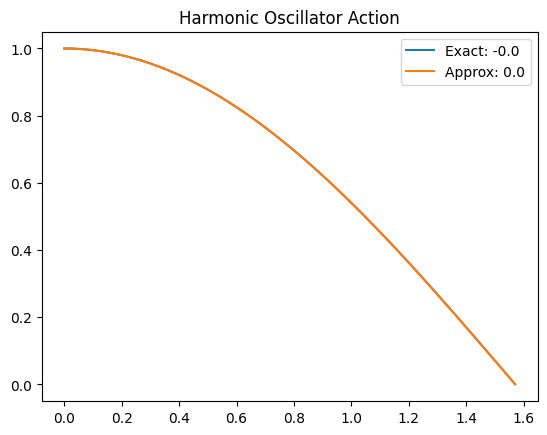

In [32]:
plt.plot(t,q_exact,label=f"Exact: {np.round(S_exact,3)}")
plt.plot(t,q_out,label=f"Approx: {np.round(result.fun)}")
plt.title("Harmonic Oscillator Action")
plt.legend()
plt.show()

note: making this go more than 1/2 cycle breaks it for some reason, also making nonphysical endpoints leads to a wacked out optimization

### Euler-Lagrange